# PyironFlow demo

PyironFlow provides a visual programming environment to implement and execute workflows. It uses _pyiron_workflows_ as workflow language. The graphical interface is based on the js library _xyflow_ in combination with the ipywidgets library. A workflow consists of function nodes defined as pure Python functions. Input and output of these functions can be connected to input and output channels of other nodes via edges. Examples of nodes can be found in the _pyiron_nodes_ library.

For developers only: Uncomment the following line if you have edited the .js files

In [ ]:
# !npx esbuild js/widget.jsx --minify --format=esm --bundle --outdir=static

In [1]:
%config IPCompleter.evaluation='unsafe'

## Generic example

The following example shows how to define nodes (functions) and how to connect them to construct a workflow. More details on how to construct nodes and workflows can be found in the documentation of _pyiron_workflows_.

In [2]:
import sys
from pathlib import Path
# sys.path.remove('/Users/joerg/python_projects/git_libs/pyiron-xyflow')
# sys.path.remove('/Users/joerg/python_projects/git_libs/pyiron_workflow')
sys.path
# sys.path.insert(0, str(Path(Path.cwd()).parent))

['/Users/joerg/python_projects/git_libs/pyiron_nodes',
 '/Users/joerg/python_projects/git_libs/pyiron_snippets',
 '/Users/joerg/python_projects/git_libs/pyiron_workflow',
 '/Users/joerg/python_projects/git_libs/ironflow',
 '/Users/joerg/python_projects/git_libs/pyiron-xyflow/notebooks',
 '/Users/joerg/miniforge3/envs/py12/lib/python312.zip',
 '/Users/joerg/miniforge3/envs/py12/lib/python3.12',
 '/Users/joerg/miniforge3/envs/py12/lib/python3.12/lib-dynload',
 '',
 '/Users/joerg/miniforge3/envs/py12/lib/python3.12/site-packages',
 '/Users/joerg/python_projects/git_libs/my_first_extension']

In [3]:
from pyiron_workflow import Workflow, as_function_node

In [4]:
import numpy as np

@as_function_node
def linspace(x_min: int = 0, x_max: float = 2 * np.pi, n: int = 50):

    vec = np.linspace(x_min, x_max, n)
    return vec

@as_function_node
def sin(x):
    import numpy as np
    
    vec = np.sin(x)
    return vec

@as_function_node('plot')
def plot(x, y):
    import matplotlib.pylab as plt
    
    plt.plot(x, y)
    return plt.show()

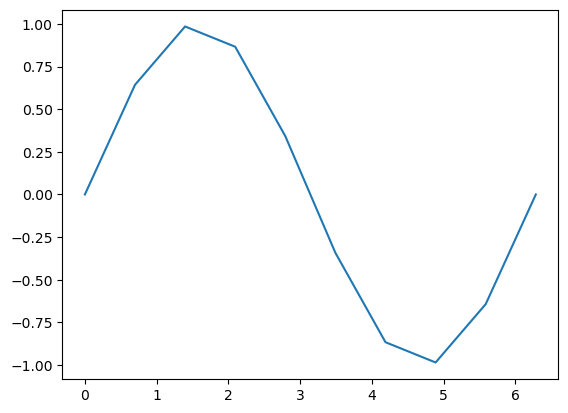

{'plot__plot': None}

In [5]:
wf = Workflow('simple_workflow')
wf.x = linspace(n=10)
wf.sin = sin(x=wf.x)
wf.plot = plot(x=wf.x, y=wf.sin)

wf.run()

The workflow _wf_ can be transferred to the visual programming interface _PyironFlow_ as shown in the cell below. To run the workflow, click on the last node (plot) and then click on the _run_ button. If you want to debug the code, you can click on any node and click run to see the output of that node. If you want to view the source code of the node, click the _source_ button.

In [7]:
import pyironflow.

In [6]:
from python.pyironflow import PyironFlow

pf = PyironFlow([wf])
pf.gui

ModuleNotFoundError: No module named 'python'

## Employ the node library to build more complex workflows

The _pyiron_nodes_ library collects nodes/functions from different domains. If you are using git clone to add the pyiron_nodes library, modify the following commands to add the pyiron_nodes path to your PYIRONPATH environment variable.

In [7]:
PyironFlow??

Init signature: PyironFlow(wf_list=None, hash_nodes=False)
Docstring:      <no docstring>
Source:        
class PyironFlow:
    def __init__(self, wf_list=None, hash_nodes=False):
        # generate empty default workflow if workflow list is empty
        if wf_list is None:
            wf_list = []
        if len(wf_list) == 0:
            wf_list = [Workflow('workflow')]

        self.workflows = wf_list

        self.out_log = widgets.Output(layout={'border': '1px solid black', 'width': '800px'})
        self.out_widget = widgets.Output(layout={'border': '1px solid black', 'min_width': '400px'})
        self.wf_widgets = [PyironFlowWidget(wf, log=self.out_log, out_widget=self.out_widget, hash_nodes=hash_nodes)
                           for wf in self.workflows]
        self.view_flows = self.view_flows()
        self.tree_view = TreeView(flow_widget=self.wf_widgets[0], log=self.out_log)
        self.accordion = widgets.Accordion(children=[self.tree_view.gui, self.out_widget, self.o

### Elastic constants

In [ ]:
from pyiron_workflow import Workflow   

import pyiron_nodes as pn

wf = Workflow('compute_elastic_constants')
wf.engine = pn.atomistic.engine.ase.M3GNet()
wf.bulk = pn.atomistic.structure.build.Bulk('Pb', cubic=True)
wf.input_elastic = pn.atomistic.property.elastic.InputElasticTensor()
wf.elastic = pn.atomistic.property.elastic.ElasticConstants(structure=wf.bulk, engine=wf.engine, parameters=wf.input_elastic)

In [ ]:
wf.draw();

In [ ]:
wf.bulk.position = (10, 0)
'position' in dir(wf.bulk)

In [ ]:
from python.pyironflow import PyironFlow

pf = PyironFlow([wf], hash_nodes=True)
pf.gui

### Some extra features

#### Get the nodes from the gui

In [ ]:
import json
json.loads(pf.wf_widgets[0].gui.nodes);

#### Show the workflow widget from tab_0

In [ ]:
pf.wf_widgets[0].gui

#### Get the current workflow from the gui and visualize it (test completeness of switching between graphical and programmatic representation)

In [ ]:
from python.pyironflow import PyironFlow

wf = pf.get_workflow()

pf = PyironFlow([wf])
pf.gui

### Phonons

The following example computes the phonon total density of states. The dos node returns a dataframe. To plot it use from the Node Library the _PlotDataFrame_ module *(Node Library -> plotting -> PlotDataFrame)*

In [ ]:
from pyiron_workflow import Workflow   

import pyiron_nodes as pn

wf = Workflow('phonons')
wf.engine = pn.atomistic.engine.ase.M3GNet()
wf.bulk = pn.atomistic.structure.build.CubicBulkCell('Pb', cell_size=3)
wf.phonopy = pn.atomistic.property.phonons.CreatePhonopy(structure=wf.bulk, engine=wf.engine) #, parameters=parameters)
wf.dos = pn.atomistic.property.phonons.GetTotalDos(phonopy=wf.phonopy.outputs.phonopy)

# wf.run()


In [ ]:
pf = PyironFlow([wf], hash_nodes=True)
pf.gui

### Built Lammps workflow from scratch

This example demonstrates how to construct a low-level workflow to run a file-based executable using Lammps as a prototype. The concepts can be extended to any type of executable.

In [ ]:
from pyiron_workflow import Workflow   
import pyiron_nodes as pn


In [ ]:
wf = Workflow('Lammps')
wf.structure = pn.atomistic.structure.build.Bulk('Al', cubic=True)
wf.repeat = pn.atomistic.structure.transform.Repeat(structure=wf.structure, repeat_scalar=3)

wf.calculator = pn.lammps.CalcMD() # temperature=300, n_ionic_steps=10_000)
wf.potential = pn.atomistic.engine.lammps.Potential(
    structure=wf.structure, name='1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1'
)

wf.init_lammps = pn.atomistic.engine.lammps.InitLammps(
        structure=wf.repeat,
        potential=wf.potential,
        calculator=wf.calculator,
        working_directory="test2",
    )

wf.shell = pn.atomistic.engine.lammps.Shell(
        # command=ExecutablePathResolver(module="lammps", code="lammps").path(),
        working_directory=wf.init_lammps,
    )

wf.ParseLogFile = pn.atomistic.engine.lammps.ParseLogFile(
    log_file=wf.shell.outputs.log
)
wf.ParseDumpFile = pn.atomistic.engine.lammps.ParseDumpFile(
    dump_file=wf.shell.outputs.dump
)
wf.Collect = pn.atomistic.engine.lammps.Collect(
    out_dump=wf.ParseDumpFile.outputs.dump,
    out_log=wf.ParseLogFile.outputs.log,
    calc_mode='md',
)

wf.get_energy_pot = pn.atomistic.engine.lammps.GetEnergyPot(generic=wf.Collect)

out = wf.run()

In [ ]:
wf.get_energy_pot.pull()[0:-1]

In [ ]:
from python.pyironflow import PyironFlow

pf = PyironFlow([wf])
pf.gui

### Use Lammps Macro

The low-level workflow above has been converted into a macro 'Code'. The application of such a high-level macro is shown below. 

In [ ]:
wf = Workflow('lammps_macro')
wf.bulk = pn.atomistic.structure.build.CubicBulkCell('Pb', cell_size=3)
wf.inp_calc_md = pn.atomistic.calculator.data.InputCalcMD()
wf.lammps = pn.atomistic.engine.lammps.Code(structure=wf.bulk, calculator=wf.inp_calc_md) 
wf.energies = pn.atomistic.engine.lammps.GetEnergyPot(generic=wf.lammps)
wf.plot = pn.plotting.Plot(y=wf.energies)

wf.run()

In [ ]:
pf = PyironFlow([wf])
pf.gui